# Tutoriel MID Générique
<u>Objectif</u> : Illustrer les propriétés de la MID.

Concrètement, nous considérons un système qui a un controle par une loi de commande retardée (expression mathématique) et l'on prend compte et tirons avantage de ce retard dans le calcul des gains de la loi de commande retardée pour stabiliser le système.

<u> Informations importantes </u> :

- Stabilité : Lorsque l'on a l'équation décrivant un système dans l'espace de Laplace (transformée de Laplace), la stabilité est traduite par l'ensemble des racines (complexes) de l'équation ayant leurs parties réelles négatives. On dit que les racines sont à gauche (de l'axe des ordonnées).
- Transformée de Laplace (juste pour info) : Dans notre cas, la partie la plus importante dans la transformée de Laplace est la dérivation, c'est ce qui nous permet de passer d'une équation différentielle à une équation polynomiale. L'idée très grossière est qu'une dérivée d'ordre $n$ dans l'espace "classique"/"temporel" correspond à une multiplication par un terme $s^n$ dans l'espace de Laplace (fréquentiel). Donc, par exemple, $4\times k \times y''(t)\rightarrow 4ks^2y(s)$

On traite une équation différentielle du type :
$$
\frac{d^n y(t)}{dt^n} + \sum\limits_{i=0}^{n-1}a_i\frac{d^i y(t)}{dt^i} + \sum\limits_{j=0}^m \alpha_j\frac{d^j y(t-\tau)}{dt^j}=0
$$

- $n, m\in\mathbb{N}, n>m$
- $a_i, \alpha_j \in \mathbb{R}$
- $s\in\mathbb{C}$,
- $\tau \in \mathbb{R}$

Par une transformée de Laplace :
$$
Q(s) = s^n+a_{n-1}s^{n-1}+...+a_0 + \left[\alpha_ms^m+...+\alpha_0\right]e^{-s\tau}
$$

Cette équation est polynomiale et non différentielle ce qui la rend beaucoup plus simple à traiter.

On souhaite réaliser ce que l'on appelle un placement de pôle. Cela signifie dans ce cas que l'on veut trouver les coefficients ($a_i$ et $\alpha_j$ parfois notés $b_j$) soient de telle sorte que $Q(s_0)=0$. 

On connaît donc une valeur de racine à "forcer" pour le quasipolynôme en jouant sur les coefficients.

Le code suivant a été développé sur la base du pseudo-code de la MID Générique, décrit par Franck, que vous trouverez à la fin du document.

## Packages nécessaires

On utilise numpy pour les opérations mathématiques numériques telles que les opérations matricielles (produit matriciel par exemple).

Sympy permet de réaliser des calculs en symbolique sur Python et donc de travailler avec des expressions mathématiques et en numérique.

In [1]:
# pip install sympy si nécessaire (module not found), pareil avec cxroots
%matplotlib notebook
import numpy as np
import sympy as sp
import cxroots as cx
import matplotlib.pyplot as plt

D:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Paramètres
$n$ est le degré du polynôme non retardé, $m$ est celui du polynôme retardé (celui multiplié par l'exponentielle).

$s_0$ est le taux de décroissance exponentiel. Il s'agit de la racine dominante que l'on souhaite assigner (celle la plus à droite lorsqu'on plot les racines). Celui-ci doit être négatif pour que le système soit stable. Un $s_0$ positif signifie donc que le système est instable.

$\tau$ est le retard considéré.

In [2]:
n = 2
m = 1
s0 = -5
value_tau = 1

## Création de symboles

Les variables s, tau, a et alpha vont désormais correspondre à des symboles et non des variables numériques.

On considère dans nos cas concrets que les $a_i$ correspondent aux paramètres du système (de son équation) et les $\alpha_j$ correspondent aux gains de la loi de commande retardée.

In [3]:
s = sp.symbols('s')  # define variable s for our problem to be solved
tau = sp.symbols('tau')  # define variable tau : delay

a = sp.symbols(["a{:d}".format(i) for i in range(n)], real=True)
alpha = sp.symbols(["alpha{:d}".format(i) for i in range(m + 1)], real=True)



## Création du quasipolynome

In [4]:
Polynomial = s**n + np.array(a).dot([s**i for i in range(n)]) # Revient à faire s^n + a_{n-1}^{n-1}...
Delayed = np.array(alpha).dot([s**i for i in range(m+1)])*sp.exp(-s*tau) # Revient à faire 
#b^m*s^m + b_{m-1}^{m-1}...
Q = Polynomial + Delayed 
Q

a0 + a1*s + s**2 + (alpha0 + alpha1*s)*exp(-s*tau)

## Créer le système à résoudre

Dans ce cadre de MID générique, on a $n+m+1$ inconnues qui sont les $a_i$ ($n$ variables de $0$ à $n-1$ inclus) et $\alpha_j$ ($m+1$ variables de $0$ à $m$ inclus).

On parle donc de multiplicité de $n+m+1$ et on souhaite donc avoir $n+m+1$ équations. Pour l'instant nous avons une première équation qui correspond à notre quasipolynôme (=0). Étant en multiplicité $n+m+1$ en ***Multiplicity Induced Dominancy*** (MID), on va chercher à ce que la racine (en $s$) que l'on souhaite placer en $s_0$ soit de multiplicité $n+m+1$. Cela revient à ce que les dérivées successives de $Q$ par rapport à $s$ soient nulles lorsque $s=s_0$.

Il faut donc calculer les $n+m$ dérivées suivantes ce qui se fait très simplement avec Sympy en utilisant la méthode <i>diff</i> en spécifiant en argument la variable de différenciation.

In [5]:
SysDerivatif = [Q]
print(Q)
for i in range(n+m+1):
    DerniereDerivee = SysDerivatif[-1]
    SysDerivatif.append(DerniereDerivee.diff(s)) # Dérivée par rapport à s
    print(SysDerivatif[-1])

a0 + a1*s + s**2 + (alpha0 + alpha1*s)*exp(-s*tau)
a1 + alpha1*exp(-s*tau) + 2*s - tau*(alpha0 + alpha1*s)*exp(-s*tau)
-2*alpha1*tau*exp(-s*tau) + tau**2*(alpha0 + alpha1*s)*exp(-s*tau) + 2
3*alpha1*tau**2*exp(-s*tau) - tau**3*(alpha0 + alpha1*s)*exp(-s*tau)
-4*alpha1*tau**3*exp(-s*tau) + tau**4*(alpha0 + alpha1*s)*exp(-s*tau)


## Résolution du système

Après avoir créé le système dérivatif, il suffit de le résoudre avec Sympy en spécifiant bien que l'on souhaite obtenir les expressions des $a_i$ et des $\alpha_j$.

Ici, on a bien $n+m+1 = 4$ ce qui nous retourne $a_0, a_1, \alpha_0$ et $\alpha_1$ en gardant bien à l'esprit que $a_2=1$.

Le ".args[0]" sert à extraire les solutions à partir du solveur qui retourne un set.

In [6]:
sol = sp.linsolve(SysDerivatif[:-1], alpha + a).args[0] # Solveur selon les alpha et les a
sol

(2*s*exp(s*tau)/tau - 6*exp(s*tau)/tau**2, -2*exp(s*tau)/tau, s**2 + 4*s/tau + 6/tau**2, -2*s - 4/tau)

## Vérification de l'ordre des inconnues

On vérifie que les variables retournées par le solveur sont dans ce sens : $\alpha_0,\alpha_1,a_0,a_1$.

In [7]:
alpha + a

[alpha0, alpha1, a0, a1]

In [8]:
solNum = sol.subs({s : s0})
solNum = solNum.subs({tau : value_tau})
solNum

(-16*exp(-5), -2*exp(-5), 11, 6)

In [9]:
a_num = list(solNum[m + 1:])
alpha_num = list(solNum[:m + 1])
print(a_num, alpha_num)

[11, 6] [-16*exp(-5), -2*exp(-5)]


## Rootfinding

Après avoir calculé ces coefficients, on souhaite vérifier de manière visuelle que les résultats trouvés fonctionnent. Pour cela, on reconstitue le quasipolynôme mais en remplaçant cette fois ci les coefficients par les valeurs trouvées. On remplace également $\tau$ par sa valeur et l'on dérive ensuite ce quasipolynôme par rapport à s. La dérivée est utile pour le rootfinding qui est l'algorithme qui va nous trouver les racines du quasipolynôme dans un contour donné.

La définition d'un contour est indispensable pour du rootfinding complexe. On a ici choisi un rectangle entre $-100$ et $10$ en abscisse et $-100$ et $-100$ en ordonnée.

In [10]:
QNumerique = s**n + np.array(a_num).dot([s**i for i in range(n)])+\
            np.array(alpha_num).dot([s**i for i in range(m+1)])*sp.exp(-s*tau)

# Possibilité de faire ça de manière plus propre avec un "zip"

QNumerique = QNumerique.subs(tau, value_tau)
QNumerique

s**2 + 6*s + (-2*s*exp(-5) - 16*exp(-5))*exp(-s) + 11

In [11]:
sysRootFinding = [QNumerique, QNumerique.diff(s)]
sysFunc = [sp.lambdify(s, i) for i in sysRootFinding]
rect = cx.Rectangle([-100, 10], [-100, 100])
roots = rect.roots(sysFunc[0], sysFunc[1], rootErrTol=1e-5, absTol=1e-5, M = n + m + 1)
print(roots)
xroot = np.real(roots[0])
yroot = np.imag(roots[0])

 Multiplicity |               Root              
------------------------------------------------
      1       | -8.903772521426 -98.849979505853i
      1       | -8.903772521426 +98.849979505853i
      1       | -8.838409259546 -92.560024714680i
      1       | -8.838409259546 +92.560024714680i
      1       | -8.768480972175 -86.269136627702i
      1       | -8.768480972175 +86.269136627702i
      1       | -8.693302366816 -79.977103585485i
      1       | -8.693302366816 +79.977103585485i
      1       | -8.612021236139 -73.683643809653i
      1       | -8.612021236139 +73.683643809653i
      1       | -8.523559382989 -67.388373443179i
      1       | -8.523559382989 +67.388373443179i
      1       | -8.426524806933 -61.090755200800i
      1       | -8.426524806933 +61.090755200800i
      1       | -8.319076500982 -54.790012244816i
      1       | -8.319076500982 +54.790012244816i
      1       | -8.198707288311 -48.484976045378i
      1       | -8.198707288311 +48.484976045378i
  

<IPython.core.display.Javascript object>


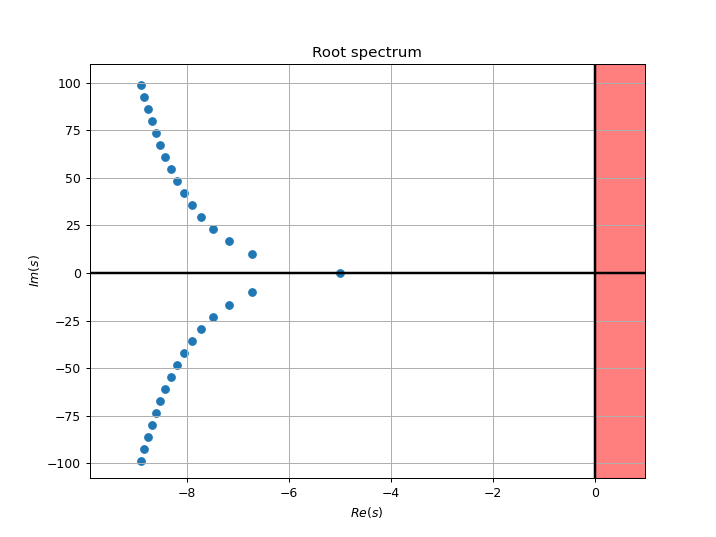

Text(0, 0.5, '$Im(s)$')

In [12]:
plt.figure(figsize=(8,6))
plt.axhline(linewidth=2, color='black')
plt.axvline(linewidth=2, color='black')
plt.axvspan(0, 1, alpha=0.5, color='red')
plt.scatter(xroot, yroot)
plt.grid()
plt.title("Root spectrum")
plt.xlabel(r"$Re(s)$")
plt.ylabel(r"$Im(s)$")

En résumé : 
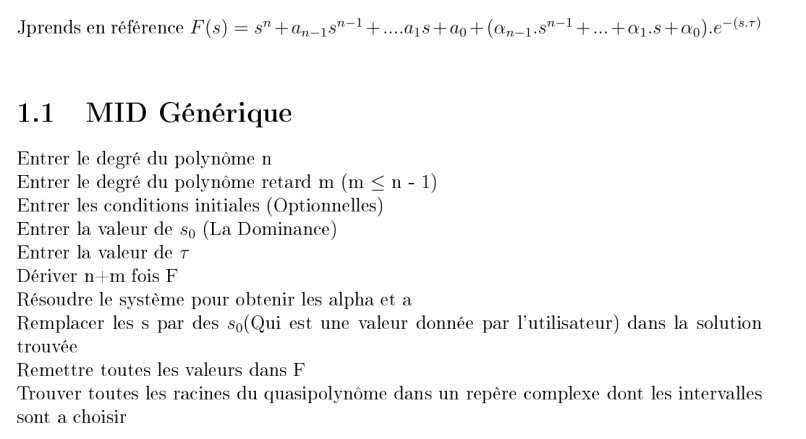